# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [23]:
# Importing the necessary libraries

import numpy as np
import os
import imageio.v2 as imageio
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import cv2
import matplotlib.pyplot as plt
import abc
import os
import numpy as np
import datetime
import cv2
import imageio.v2 as imageio
from PIL import Image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from PIL import Image

We set the random seed so that the results don't vary drastically.

In [25]:
import numpy as np
import random as rn
import tensorflow as tf

# Set seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

# Import Keras from TensorFlow
from tensorflow import keras
from tensorflow.keras import backend as K

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [24]:
train_doc = np.random.permutation(open('/Users/mayank.bhardwaj/upgr/RNN Assignment/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/Users/mayank.bhardwaj/upgr/RNN Assignment/Project_data/val.csv').readlines())
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [29]:
import numpy as np
import os
import random
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

def generator(source_path, folder_list, batch_size, is_train=False, augmention=False, debug=False):
    img_idx = seq_idx  # list of frame indices to sample from video
    x = len(img_idx)
    y, z = dim_x, dim_y  # target height, width

    while True:
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)

        num_batches = (len(t) + batch_size - 1) // batch_size  # ensure all batches are covered

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break  # skip incomplete batch

                folder_str = t[folder_idx]
                folder_path = os.path.join(source_path, folder_str.split(';')[0])
                imgs = sorted(os.listdir(folder_path))

                # Randomly select augmentation
                aug_type = random.randint(0, 4) if is_train and augmention and random.randint(0, 1) == 1 else None

                if debug:
                    plt.figure(figsize=(20, 5))

                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imageio.imread(image_path).astype(np.float32)

                    # Crop to square
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[1]
                        image = image[crop_start:crop_end, :]

                    # Ensure image is uint8 before resizing
                    image = np.clip(image, 0, 255).astype(np.uint8)
                    image_pil = Image.fromarray(image).resize((z, y), Image.Resampling.LANCZOS)

                    if aug_type is not None:
                        if aug_type == 0:
                            image_pil = image_pil.filter(ImageFilter.EDGE_ENHANCE)
                        elif aug_type == 1:
                            image_pil = image_pil.filter(ImageFilter.GaussianBlur(radius=1))
                        elif aug_type == 2:
                            image_pil = image_pil.filter(ImageFilter.DETAIL)
                        elif aug_type == 3:
                            image_pil = image_pil.filter(ImageFilter.SHARPEN)
                        elif aug_type == 4:
                            image_pil = ImageEnhance.Brightness(image_pil).enhance(1.5)

                    resized_im = np.array(image_pil)

                    if debug:
                        plt.subplot(2, x, idx + 1)
                        plt.imshow(image.astype(np.uint8))
                        plt.title("Original")
                        plt.subplot(2, x, idx + x + 1)
                        plt.imshow(resized_im)
                        plt.title("Resized/Augmented")

                    # Normalize to [0, 1]
                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255.0

                label_index = int(folder_str.strip().split(';')[2])
                batch_labels[folder, label_index] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [30]:
curr_dt_time = datetime.datetime.now()
train_path = '/Users/mayank.bhardwaj/upgr/RNN Assignment/Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  '/Users/mayank.bhardwaj/upgr/RNN Assignment/Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


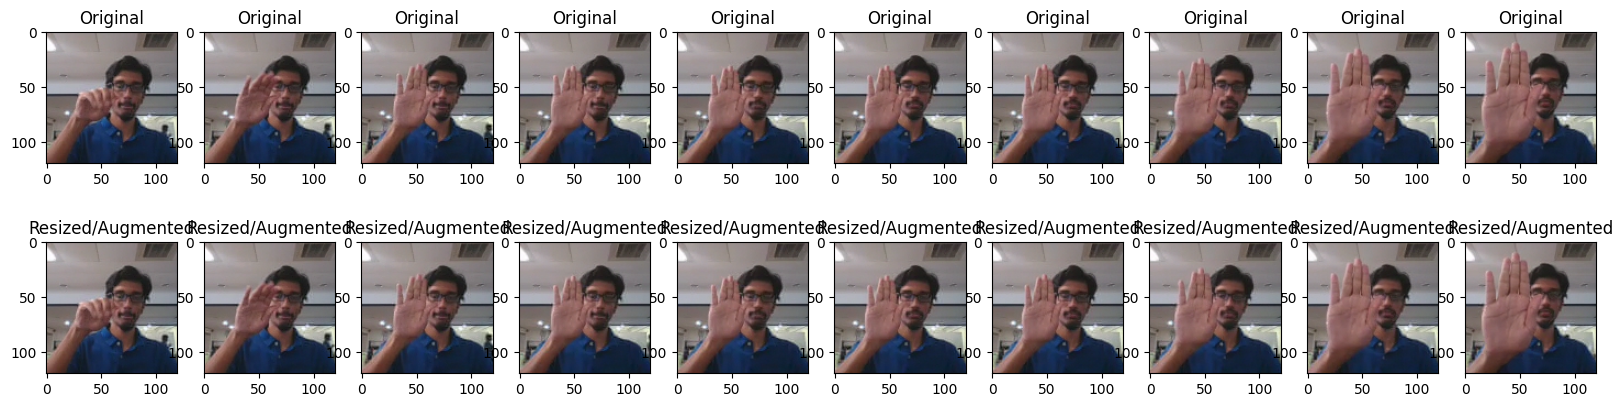

In [31]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, GRU, Flatten, TimeDistributed, Bidirectional,
    BatchNormalization, Activation, Dropout,
    GlobalAveragePooling2D, GlobalAveragePooling3D,
    ConvLSTM2D, Conv2D, Conv3D,
    MaxPooling2D, MaxPooling3D
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
import random
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)
# Define input shape for the first layer (Conv3D, etc.)
input_shape = (len(seq_idx), dim_x, dim_y, 3)

### Experiment - 1 & 2
**Conv3D**

In [9]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment - 3
**Conv3D**

In [10]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(3, 2, 2)))

# model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment - 4
**Conv3D**

In [11]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment - 5 & 6
**Conv3D**

In [12]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 7 & 8
**Conv3D**

In [13]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# #model.add(Dropout(0.2))
# model.add(Dropout(0.5))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# #model.add(Dropout(0.2))
# model.add(Dropout(0.5))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# #model.add(Dropout(0.2))
# model.add(Dropout(0.5))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# #model.add(Dropout(0.2))
# model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 9
**Conv3D**

In [14]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 10
**Conv3D**

In [15]:
# loss: 0.1388 - categorical_accuracy: 0.9539 - val_loss: 0.1661 - val_categorical_accuracy: 0.9297
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 11
**TimeDistributed Conv2D + GRU**

In [16]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 12
**TimeDistributed Conv2D + GRU**

In [17]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 13
**TimeDistributed Conv2D + Dense**

In [18]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(128, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(GlobalAveragePooling3D())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment - 14
**TimeDistributed + ConvLSTM2D**

In [19]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Conv2D(16, (3,3), activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(
#     ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Dense(64, activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

# Final Model

In [36]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [39]:
optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 118, 118,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 118, 118,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 116, 116,   │         1,168 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 116, 116,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 114, 114, 8)    │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 114, 114, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 114, 114, 64)   │           576 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 114, 114, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,781 (53.83 KB)

 Trainable params: 13,589 (53.08 KB)

 Non-trainable params: 192 (768.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [40]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [42]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'  
)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [43]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [46]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3074 - loss: 1.5000
Epoch 1: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00001-1.38744-0.35268-1.47074-0.18750.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - categorical_accuracy: 0.3095 - loss: 1.4949 - val_categorical_accuracy: 0.1875 - val_loss: 1.4707 - learning_rate: 0.0100
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5061 - loss: 1.1504
Epoch 2: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00002-1.14236-0.51190-1.72690-0.16406.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.5064 - loss: 1.1501 - val_categorical_accuracy: 0.1641 - val_loss: 1.7269 - learning_rate: 0.0100
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5450 - loss: 1.0193
Epoch 3: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00003-0.98077-0.55506-1.69867-0.12500.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.5454 - loss: 1.0175 - val_categorical_accuracy: 0.1250 - val_loss: 1.6987 - learning_rate: 0.0100
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6204 - loss: 0.8698
Epoch 4: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00004-0.86162-0.62054-1.44022-0.10156.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.6204 - loss: 0.8695 - val_categorical_accuracy: 0.1016 - val_loss: 1.4402 - learning_rate: 0.0100
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6348 - loss: 0.8449
Epoch 5: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00005-0.85667-0.61161-1.39031-0.14844.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.6337 - loss: 0.8454 - val_categorical_accuracy: 0.1484 - val_loss: 1.3903 - learning_rate: 0.0100
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6176 - loss: 0.9199
Epoch 6: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00006-0.86691-0.63244-1.38143-0.20312.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.6183 - loss: 0.9175 - val_categorical_accuracy: 0.2031 - val_loss: 1.3814 - learning_rate: 0.0100
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6738 - loss: 0.8114
Epoch 7: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00007-0.85421-0.64137-1.67229-0.23438.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.6723 - loss: 0.8134 - val_categorical_accuracy: 0.2344 - val_loss: 1.6723 - learning_rate: 0.0100
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7013 - loss: 0.7179
Epoch 8: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00008-0.75795-0.66369-1.45250-0.20312.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.6996 - loss: 0.7197 - val_categorical_accuracy: 0.2031 - val_loss: 1.4525 - learning_rate: 0.0100
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6205 - loss: 0.8574
Epoch 9: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00009-0.88125-0.61012-3.90876-0.16406.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.6200 - loss: 0.8585 - val_categorical_accuracy: 0.1641 - val_loss: 3.9088 - learning_rate: 0.0100
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7003 - loss: 0.7874
Epoch 10: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00010-0.86653-0.64435-1.96586-0.17188.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - categorical_accuracy: 0.6978 - loss: 0.7910 - val_categorical_accuracy: 0.1719 - val_loss: 1.9659 - learning_rate: 0.0100
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6356 - loss: 0.9383
Epoch 11: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00011-0.89157-0.62351-3.58282-0.20312.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.6351 - loss: 0.9362 - val_categorical_accuracy: 0.2031 - val_loss: 3.5828 - learning_rate: 0.0100
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6838 - loss: 0.8198
Epoch 12: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00012-0.81650-0.68155-2.69709-0.25000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.6837 - loss: 0.8196 - val_categorical_accuracy: 0.2500 - val_loss: 2.6971 - learning_rate: 0.0020
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7204 - loss: 0.6270
Epoch 13: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00013-0.66318-0.70089-2.25116-0.28906.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.7195 - loss: 0.6287 - val_categorical_accuracy: 0.2891 - val_loss: 2.2512 - learning_rate: 0.0020
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7556 - loss: 0.6113
Epoch 14: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00014-0.65940-0.72024-3.34540-0.28906.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.7540 - loss: 0.6134 - val_categorical_accuracy: 0.2891 - val_loss: 3.3454 - learning_rate: 0.0020
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7454 - loss: 0.6563
Epoch 15: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00015-0.65716-0.70833-3.07523-0.25000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - categorical_accuracy: 0.7437 - loss: 0.6564 - val_categorical_accuracy: 0.2500 - val_loss: 3.0752 - learning_rate: 0.0020
Epoch 16/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7286 - loss: 0.6554
Epoch 16: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00016-0.70371-0.70238-2.87167-0.26562.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.001.
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - categorical_accuracy: 0.7274 - loss: 0.6576 - val_categorical_accuracy: 0.2656 - val_loss: 2.8717 - learning_rate: 0.0020
Epoch 17/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7269 - loss: 0.6533
Epoch 17: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00017-0.63868-0.72619-2.64498-0.25000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - categorical_accuracy: 0.7268 - loss: 0.6527 - val_categorical_accuracy: 0.2500 - val_loss: 2.6450 - learning_rate: 0.0010
Epoch 18/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7428 - loss: 0.6516
Epoch 18: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00018-0.63738-0.72024-2.35998-0.25000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.7418 - loss: 0.6510 - val_categorical_accuracy: 0.2500 - val_loss: 2.3600 - learning_rate: 0.0010
Epoch 19/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7656 - loss: 0.5759
Epoch 19: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00019-0.61092-0.71875-1.79301-0.28906.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.7635 - loss: 0.5775 - val_categorical_accuracy: 0.2891 - val_loss: 1.7930 - learning_rate: 0.0010
Epoch 20/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7805 - loss: 0.5764
Epoch 20: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00020-0.62316-0.74256-1.94525-0.28125.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.7788 - loss: 0.5786 - val_categorical_accuracy: 0.2812 - val_loss: 1.9452 - learning_rate: 0.0010
Epoch 21/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7656 - loss: 0.5907
Epoch 21: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00021-0.60715-0.73661-1.79386-0.26562.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.7643 - loss: 0.5914 - val_categorical_accuracy: 0.2656 - val_loss: 1.7939 - learning_rate: 0.0010
Epoch 22/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7048 - loss: 0.6344
Epoch 22: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00022-0.61332-0.71577-1.63706-0.28906.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.7053 - loss: 0.6334 - val_categorical_accuracy: 0.2891 - val_loss: 1.6371 - learning_rate: 0.0010
Epoch 23/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7626 - loss: 0.6065
Epoch 23: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00023-0.64433-0.72619-1.68174-0.27344.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.7609 - loss: 0.6083 - val_categorical_accuracy: 0.2734 - val_loss: 1.6817 - learning_rate: 0.0010
Epoch 24/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7491 - loss: 0.6157
Epoch 24: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00024-0.62394-0.71726-1.33310-0.32812.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.7477 - loss: 0.6160 - val_categorical_accuracy: 0.3281 - val_loss: 1.3331 - learning_rate: 0.0010
Epoch 25/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7122 - loss: 0.6552
Epoch 25: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00025-0.66094-0.69940-1.46674-0.30469.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.7116 - loss: 0.6555 - val_categorical_accuracy: 0.3047 - val_loss: 1.4667 - learning_rate: 0.0010
Epoch 26/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7108 - loss: 0.6445
Epoch 26: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00026-0.66328-0.68304-1.07005-0.40625.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.7096 - loss: 0.6453 - val_categorical_accuracy: 0.4062 - val_loss: 1.0701 - learning_rate: 0.0010
Epoch 27/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7408 - loss: 0.6273
Epoch 27: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00027-0.64226-0.71280-1.34884-0.31250.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.7395 - loss: 0.6280 - val_categorical_accuracy: 0.3125 - val_loss: 1.3488 - learning_rate: 0.0010
Epoch 28/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7344 - loss: 0.6015
Epoch 28: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00028-0.61760-0.70685-1.12635-0.40625.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.7331 - loss: 0.6022 - val_categorical_accuracy: 0.4062 - val_loss: 1.1263 - learning_rate: 0.0010
Epoch 29/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7409 - loss: 0.6114
Epoch 29: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00029-0.63528-0.70238-1.07232-0.39844.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.7391 - loss: 0.6125 - val_categorical_accuracy: 0.3984 - val_loss: 1.0723 - learning_rate: 0.0010
Epoch 30/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7533 - loss: 0.6083
Epoch 30: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00030-0.62307-0.72917-1.07372-0.37500.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.7522 - loss: 0.6090 - val_categorical_accuracy: 0.3750 - val_loss: 1.0737 - learning_rate: 0.0010
Epoch 31/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7493 - loss: 0.6066
Epoch 31: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00031-0.64293-0.71429-1.12936-0.35938.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.7477 - loss: 0.6083 - val_categorical_accuracy: 0.3594 - val_loss: 1.1294 - learning_rate: 0.0010
Epoch 32/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6981 - loss: 0.6309
Epoch 32: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00032-0.65548-0.68304-1.07297-0.39844.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - categorical_accuracy: 0.6974 - loss: 0.6320 - val_categorical_accuracy: 0.3984 - val_loss: 1.0730 - learning_rate: 0.0010
Epoch 33/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7206 - loss: 0.6452
Epoch 33: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00033-0.65101-0.70685-1.16699-0.36719.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.7200 - loss: 0.6455 - val_categorical_accuracy: 0.3672 - val_loss: 1.1670 - learning_rate: 0.0010
Epoch 34/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7394 - loss: 0.5865
Epoch 34: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00034-0.62942-0.71131-1.06277-0.40625.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - categorical_accuracy: 0.7381 - loss: 0.5885 - val_categorical_accuracy: 0.4062 - val_loss: 1.0628 - learning_rate: 0.0010
Epoch 35/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7205 - loss: 0.6265
Epoch 35: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00035-0.65130-0.69345-1.05701-0.39062.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.7193 - loss: 0.6276 - val_categorical_accuracy: 0.3906 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 36/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7235 - loss: 0.6178
Epoch 36: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00036-0.61499-0.72470-1.26674-0.32812.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - categorical_accuracy: 0.7236 - loss: 0.6176 - val_categorical_accuracy: 0.3281 - val_loss: 1.2667 - learning_rate: 0.0010
Epoch 37/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7475 - loss: 0.5973
Epoch 37: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00037-0.60035-0.73363-1.24024-0.34375.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.7469 - loss: 0.5974 - val_categorical_accuracy: 0.3438 - val_loss: 1.2402 - learning_rate: 0.0010
Epoch 38/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7153 - loss: 0.6812
Epoch 38: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00038-0.65096-0.71280-1.31537-0.30469.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.7152 - loss: 0.6799 - val_categorical_accuracy: 0.3047 - val_loss: 1.3154 - learning_rate: 0.0010
Epoch 39/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7323 - loss: 0.6554
Epoch 39: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00039-0.68460-0.69792-1.36467-0.35156.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.7307 - loss: 0.6567 - val_categorical_accuracy: 0.3516 - val_loss: 1.3647 - learning_rate: 0.0010
Epoch 40/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7238 - loss: 0.7310
Epoch 40: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00040-0.70045-0.70536-1.44192-0.39062.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.7229 - loss: 0.7296 - val_categorical_accuracy: 0.3906 - val_loss: 1.4419 - learning_rate: 0.0010
Epoch 41/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7479 - loss: 0.6026
Epoch 41: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00041-0.65775-0.71577-2.28911-0.29688.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.7465 - loss: 0.6051 - val_categorical_accuracy: 0.2969 - val_loss: 2.2891 - learning_rate: 0.0010
Epoch 42/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7397 - loss: 0.6026
Epoch 42: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00042-0.63184-0.71875-2.70973-0.29688.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - categorical_accuracy: 0.7388 - loss: 0.6039 - val_categorical_accuracy: 0.2969 - val_loss: 2.7097 - learning_rate: 0.0010
Epoch 43/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7392 - loss: 0.6305
Epoch 43: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00043-0.65436-0.70536-2.43631-0.32812.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - categorical_accuracy: 0.7377 - loss: 0.6316 - val_categorical_accuracy: 0.3281 - val_loss: 2.4363 - learning_rate: 0.0010
Epoch 44/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7105 - loss: 0.6420
Epoch 44: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00044-0.68878-0.67411-2.59984-0.31250.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.7088 - loss: 0.6441 - val_categorical_accuracy: 0.3125 - val_loss: 2.5998 - learning_rate: 0.0010
Epoch 45/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7203 - loss: 0.6183
Epoch 45: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00045-0.66545-0.68452-2.41556-0.30469.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.7186 - loss: 0.6204 - val_categorical_accuracy: 0.3047 - val_loss: 2.4156 - learning_rate: 0.0010
Epoch 46/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7231 - loss: 0.7347
Epoch 46: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00046-0.84115-0.69196-1.98720-0.29688.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.7217 - loss: 0.7395 - val_categorical_accuracy: 0.2969 - val_loss: 1.9872 - learning_rate: 0.0010
Epoch 47/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4976 - loss: 2.1078
Epoch 47: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00047-2.11376-0.46280-5.70171-0.17188.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.4960 - loss: 2.1080 - val_categorical_accuracy: 0.1719 - val_loss: 5.7017 - learning_rate: 0.0010
Epoch 48/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5772 - loss: 1.1754
Epoch 48: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00048-1.08725-0.56845-4.22874-0.53906.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.5768 - loss: 1.1714 - val_categorical_accuracy: 0.5391 - val_loss: 4.2287 - learning_rate: 0.0010
Epoch 49/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6681 - loss: 0.8521
Epoch 49: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00049-0.81331-0.65774-3.79766-0.31250.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.6676 - loss: 0.8503 - val_categorical_accuracy: 0.3125 - val_loss: 3.7977 - learning_rate: 0.0010
Epoch 50/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6578 - loss: 0.8329
Epoch 50: saving model to model_init_exp_16_2025-04-0215_15_41.745167/model-00050-0.77018-0.67113-3.43104-0.32031.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - categorical_accuracy: 0.6584 - loss: 0.8301 - val_categorical_accuracy: 0.3203 - val_loss: 3.4310 - learning_rate: 0.0010


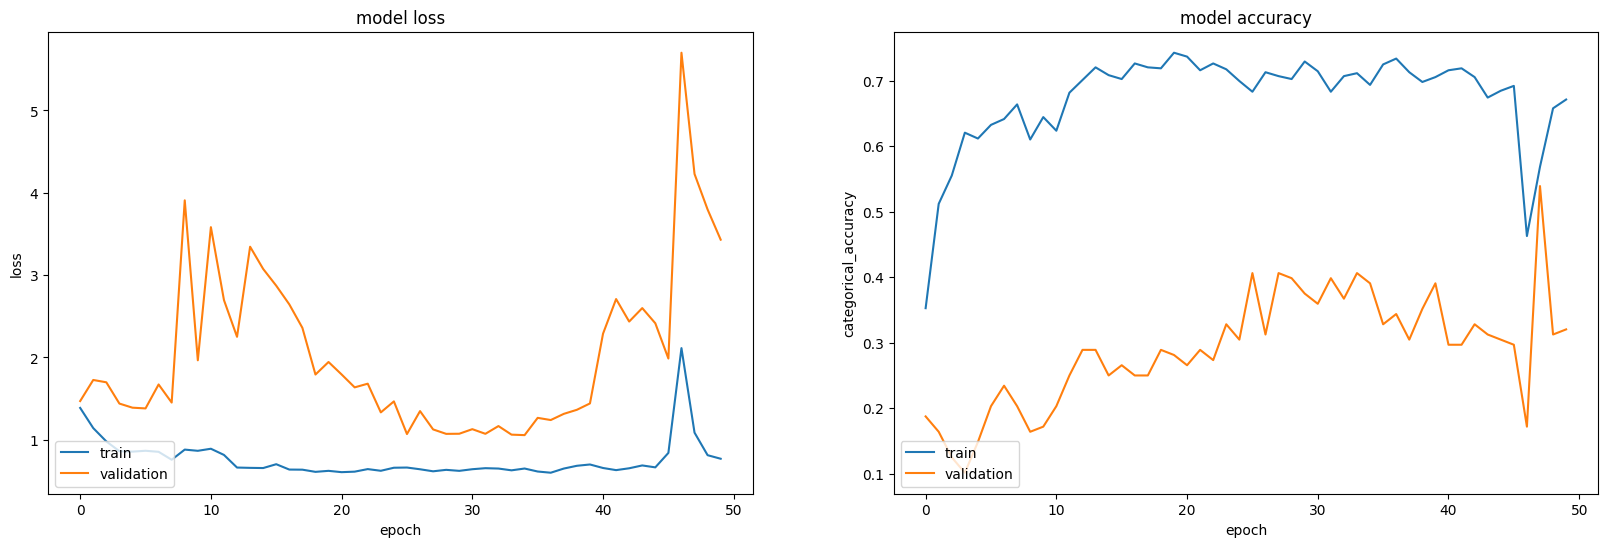

In [47]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')